<a href="https://colab.research.google.com/github/ParkStrat/StellarClassification/blob/main/StellarClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Tools and Dataset

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

In [8]:
df = pd.read_csv('/content/star_classification.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

# Cleaning Dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

Column descriptions from https://www.kaggle.com/fedesoriano/stellar-classification-dataset-sdss17

obj_ID = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS

alpha = Right Ascension angle (at J2000 epoch)

delta = Declination angle (at J2000 epoch)

u = Ultraviolet filter in the photometric system

g = Green filter in the photometric system

r = Red filter in the photometric system

i = Near Infrared filter in the photometric system

z = Infrared filter in the photometric system

run_ID = Run Number used to identify the specific scan

rereun_ID = Rerun Number to specify how the image was processed

cam_col = Camera column to identify the scanline within the run

field_ID = Field number to identify each field

spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)

class = object class (galaxy, star or quasar object)

redshift = redshift value based on the increase in wavelength

plate = plate ID, identifies each plate in SDSS

MJD = Modified Julian Date, used to indicate when a given piece of SDSS data was taken

fiber_ID = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

Checking for duplicates

In [10]:
df.duplicated().sum()

0

There are no duplicates and there does not seem to be any missing data

Checking target class balance

In [11]:
df['class'].value_counts(normalize = True)

GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: class, dtype: float64

Classes are not very evenly balanced

Removing unecessary rows due to these rows each having unique entries (such as obj_id - a unique identifier that catelogs the objet) or irrelivant to classification of the target column (such as run_ID - number used to identify the scan used to capture the data about the celestial object) 

In [12]:
df.drop(columns = ['obj_ID', 'alpha', 'delta', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'plate', 'MJD', 'fiber_ID'], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   u         100000 non-null  float64
 1   g         100000 non-null  float64
 2   r         100000 non-null  float64
 3   i         100000 non-null  float64
 4   z         100000 non-null  float64
 5   class     100000 non-null  object 
 6   redshift  100000 non-null  float64
dtypes: float64(6), object(1)
memory usage: 5.3+ MB


In [13]:
df.describe(include = 'all')

,u,g,r,i,z,class,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000,100000.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN
freq,NaN,NaN,NaN,NaN,NaN,59445,NaN
mean,21.980468,20.531387,19.645762,19.084854,18.668810,NaN,0.576661
std,31.769291,31.750292,1.854760,1.757895,31.728152,NaN,0.730707
min,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,NaN,-0.009971
25%,20.352353,18.965230,18.135828,17.732285,17.460677,NaN,0.054517
50%,22.179135,21.099835,20.125290,19.405145,19.004595,NaN,0.424173
75%,23.687440,22.123767,21.044785,20.396495,19.921120,NaN,0.704154


The min value -9999 seems like a major outlier based on the other values for each feature

---
Identifiying if the -9999 observation is a single observation  

In [14]:
df.loc[df['u'] == -9999]

,u,g,r,i,z,class,redshift
79543,-9999.0,-9999.0,18.1656,18.01675,-9999.0,STAR,0.000089


Revmoing the outlier observation and checking to ensure it is removed

In [15]:
df.drop(index = 79543, inplace = True)

In [16]:
df.describe(include = 'all')

,u,g,r,i,z,class,redshift
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999,99999.000000
unique,NaN,NaN,NaN,NaN,NaN,3,NaN
top,NaN,NaN,NaN,NaN,NaN,GALAXY,NaN
freq,NaN,NaN,NaN,NaN,NaN,59445,NaN
mean,22.080679,20.631583,19.645777,19.084865,18.768988,NaN,0.576667
std,2.251068,2.037384,1.854763,1.757900,1.765982,NaN,0.730709
min,10.996230,10.498200,9.822070,9.469903,9.612333,NaN,-0.009971
25%,20.352410,18.965240,18.135795,17.732280,17.460830,NaN,0.054522
50%,22.179140,21.099930,20.125310,19.405150,19.004600,NaN,0.424176
75%,23.687480,22.123775,21.044790,20.396510,19.921120,NaN,0.704172


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   u         99999 non-null  float64
 1   g         99999 non-null  float64
 2   r         99999 non-null  float64
 3   i         99999 non-null  float64
 4   z         99999 non-null  float64
 5   class     99999 non-null  object 
 6   redshift  99999 non-null  float64
dtypes: float64(6), object(1)
memory usage: 6.1+ MB


Data is now ready for visualization

# Exploratory Visualization

Creating histogram plots of all the numerical features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


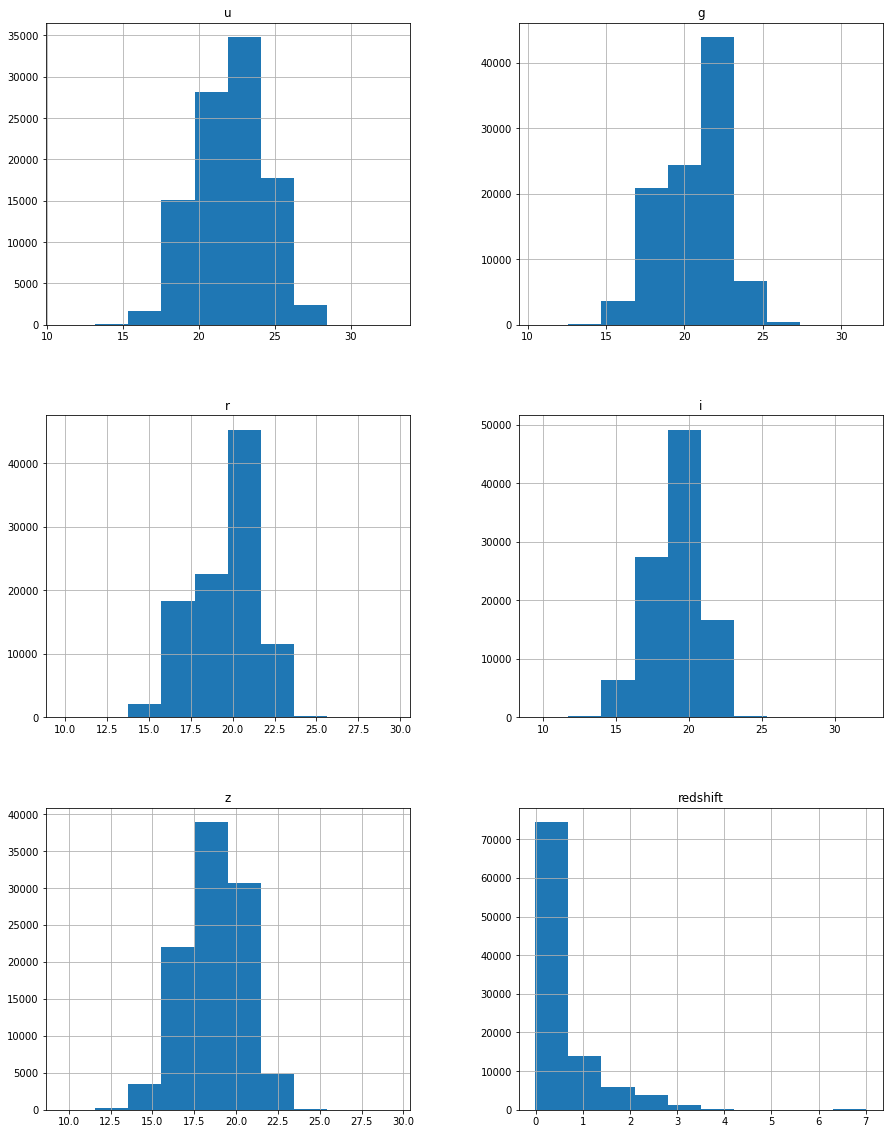

In [ ]:
fig = plt.figure(figsize = (15,20))
ax = fig.gca()
df.hist(ax = ax);

All the frequency of light features roughly follow a standard bell curve distribution and and nothing seems out of the ordinary

---
Creating a histogram to further understand the redshift distibution

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


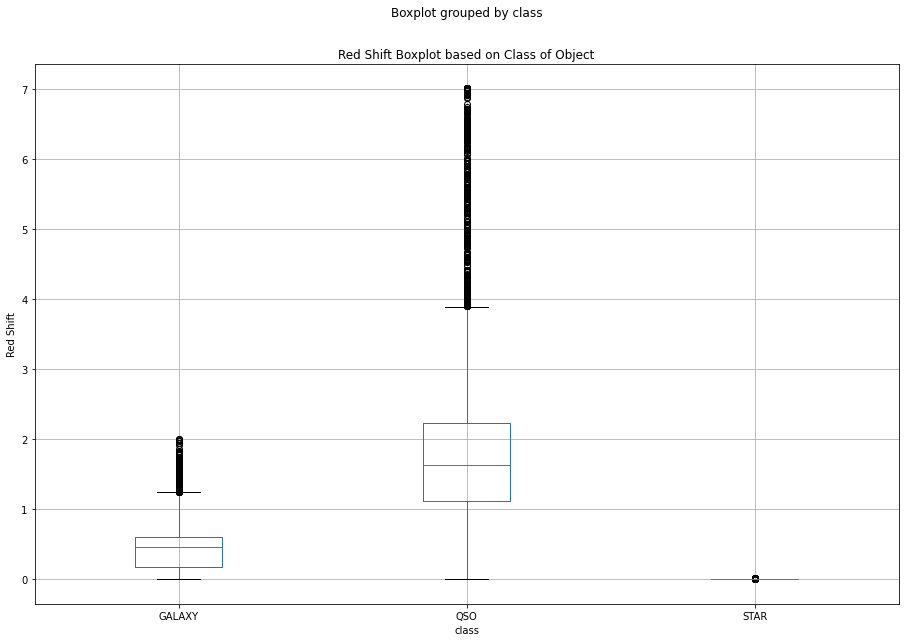

In [ ]:
df.boxplot(column = 'redshift', by = 'class', figsize = (15, 10))
plt.title('Red Shift Boxplot based on Class of Object')
plt.ylabel('Red Shift');

The Red shift histogram plot indicates the a vast majotiry of observations have a low red shift while there are some outliers. The box plot further illumintes the distribution and makes sense given that red shift is an indicator of the rate of movement away from the observer and quasars and galaxies tend to have high rates of movement relative to earth than stars (majority of observable stars are in our galaxy and are generally rotating in a similar fashion to earth around the galactic center).   

Creating a histogram of the target class

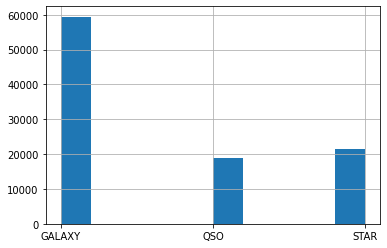

In [ ]:
df['class'].hist();

As determined earlier, there is not an even balance among the classes

* 58% - Galaxies
* 22% - Stars
* 20% - Quasar


Creating a heatmap to determine correlation between features

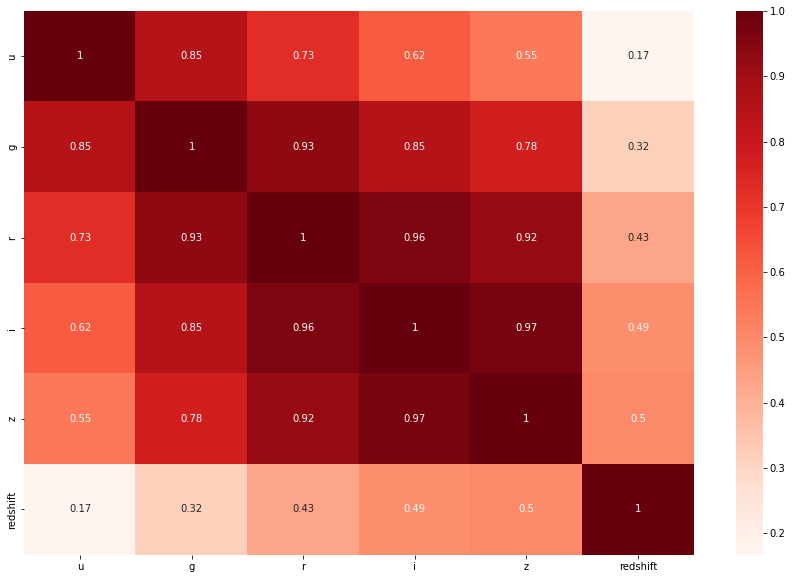

In [ ]:
corr = df.corr()
plt.subplots(figsize = (15, 10))
sns.heatmap(corr, cmap = 'Reds', annot = True);

There are numerous correlations within this dataset

* Excluding redshift, the features of this dataset are adjacent frequency ranges on the EM spectrum. Thus the ranges closest together should have and, according to the heatmap, do have strong postive correlations (as high as 0.97). As the features are further away from each other on EM spectrum, their positive correlation drops (see 'u' [Ultraviolet] and 'z' [Infrared light] - 0.55)  
* Blueshift(not a feature of this dataset) and redshift are the "compression" and 'elongation' of light waves as an object moves toward and away from an observer. Redshift occuring as an object moves away from the observer which "elongates" the wave length and since red is a longer wavelength than blue, it causes a shift toward the red wavelengths. With that in mind it would make sense that red shift would have higher correlation with those wavelengths closer to red and infrared ('redshift', 'i', 'z') than green and ultraviolet ('g' and 'u') 

# Preprocessing Dataset

Spliting training and testing data

In [ ]:
X = df.drop(columns = 'class')
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Instantiating scaler, fitting to training data, and transforming training and testing data

In [ ]:
scale = StandardScaler()
X_train_processed = scale.fit_transform(X_train)
X_test_procesed = scale.transform(X_test)

Data is ready to be run through models

# Modeling Data

## K-Nearest Neighbor Classifier

### Default KNN

Instantiate Model

In [ ]:
d_knn = KNeighborsClassifier()

Fitting to the preprocessed training data only

In [ ]:
d_knn.fit(X_train_processed, y_train)

KNeighborsClassifier()

Make predictions on the training and testing data

In [ ]:
d_knn_y_train_pred = d_knn.predict(X_train_processed)
d_knn_y_test_pred = d_knn.predict(X_test_procesed)

Evaluate model performance on both training and testing predictions

In [ ]:
d_knn_train_report = classification_report(y_train, d_knn_y_train_pred)
d_knn_test_report = classification_report(y_test, d_knn_y_test_pred)
print(f'Default KNN Performance on Training Data: \n {d_knn_train_report} \n \n Default KNN Perofrmance on the Testing Data: \n {d_knn_test_report}')

Default KNN Performance on Training Data: 
               precision    recall  f1-score   support

      GALAXY       0.98      0.97      0.97     44568
         QSO       0.97      0.94      0.95     14164
        STAR       0.95      0.99      0.97     16267

    accuracy                           0.97     74999
   macro avg       0.97      0.97      0.97     74999
weighted avg       0.97      0.97      0.97     74999
 
 
 Default KNN Perofrmance on the Testing Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.97      0.97     14877
         QSO       0.96      0.92      0.94      4797
        STAR       0.94      0.98      0.96      5326

    accuracy                           0.96     25000
   macro avg       0.96      0.96      0.96     25000
weighted avg       0.96      0.96      0.96     25000



This model performed well with default hyperparameters. The model achieved and accuracy of 0.96 on testing data and is not over fit to the training data. The area of weakest performance is differentiating between galaxies and quasars, with quasars having the highest rate of both false negatives (recall: 0.92) and false positives (percision: 0.96). Tuning should result in even better performance.

### Tuned KNN Classifier

Creating a function to determine the best n_neighbor value

In [ ]:
def knn_optimal_tune(start, stop):
  test_range = range(start, stop)
  temp_scale = StandardScaler()
  temp_X_train = temp_scale.fit_transform(X_train)
  temp_X_test = temp_scale.transform(X_test)
  best_accu = 0
  optimal_n = 0
  leafs = [15, 30, 45]
  for y in leafs:
    for x in test_range:
     temp_knn = KNeighborsClassifier(n_neighbors = x, leaf_size = y)
     temp_knn.fit(temp_X_train, y_train)
     temp_y_test_pred = temp_knn.predict(temp_X_test)
     temp_test_accu = accuracy_score(y_test, temp_y_test_pred)
     if temp_test_accu > best_accu:
       best_accu = temp_test_accu
       optimal_n = x
       optimal_leaf = y
  print(f'Best Accuracy: {best_accu} \n Optimal Number of n_neighbors: {optimal_n} \n Optimal leaf size: {optimal_leaf}')

Run above function to determine optimal n_neighbors (3-50)

In [ ]:
optimal_n1 = knn_optimal_tune(3, 50)

Best Accuracy: 0.9614 
 Optimal Number of n_neighbors: 5 
 Optimal leaf size: 15


Same score as default model

---
Running the above function for n_neighbors (51-75)

In [ ]:
optimal_n2 = knn_optimal_tune(51, 75)

Best Accuracy: 0.9514 
 Optimal Number of n_neighbors: 52 
 Optimal leaf size: 15


The default n_neighbors is 5 and the defulat leaf size is 30, with the function cycling through n_neighbors and leaf size to find the optimal, it never found perfromance greater than n_neighbors = 5 (the default) despite determining that the optimal leaf size is 15

## Random Forest Classifier 

### Default RandomForestClassifier

Instantiate default random forest model

In [ ]:
d_rf = RandomForestClassifier()

Fit model to the preprocessed training data

In [ ]:
d_rf.fit(X_train_processed, y_train)

RandomForestClassifier()

Make predictions on the traning and testing data

In [ ]:
d_rf_y_train_pred = d_rf.predict(X_train_processed)
d_rf_y_test_pred = d_rf.predict(X_test_procesed)

Evaluate model perfromance on both the training and testing dataset predictions

In [ ]:
d_rf_train_report = classification_report(y_train, d_rf_y_train_pred)
d_rf_test_report = classification_report(y_test, d_rf_y_test_pred)
print(f'Default Random Forest Performance on Training Data: \n {d_rf_train_report} \n \n Default Random Forest Perofrmance on the Testing Data: \n {d_rf_test_report}')

Default Random Forest Performance on Training Data: 
               precision    recall  f1-score   support

      GALAXY       1.00      1.00      1.00     44568
         QSO       1.00      1.00      1.00     14164
        STAR       1.00      1.00      1.00     16267

    accuracy                           1.00     74999
   macro avg       1.00      1.00      1.00     74999
weighted avg       1.00      1.00      1.00     74999
 
 
 Default Random Forest Perofrmance on the Testing Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     14877
         QSO       0.96      0.92      0.94      4797
        STAR       1.00      1.00      1.00      5326

    accuracy                           0.98     25000
   macro avg       0.98      0.97      0.97     25000
weighted avg       0.98      0.98      0.98     25000



This model performed very well with default hyperparameters. The model achieved and accuracy of 0.98 on testing data but is over fit to the training data. The area of weakest performance is differentiating between galaxies and quasars, with quasars having the highest rate of both false negatives (recall: 0.92) and false positives (percision: 0.96). Tuning should result in even better performance.

### Tuned Random Forest Model

Instantiate model

In [ ]:
gs_rf = RandomForestClassifier()

List the model's hyperparameters

In [ ]:
d_rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Setting parameters for Random Forest gridsearch

In [ ]:
depth = range(5, 15)
n_est = [25, 50, 100]
rf_param_grid = {'max_depth': depth, 'n_estimators': n_est}

Instantiate grid search

In [ ]:
rf_grid_search = GridSearchCV(gs_rf, rf_param_grid)

Fit randomforest gridsearch to preprocessed training data

In [ ]:
rf_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(5, 15),
                         'n_estimators': [25, 50, 100]})

Determine best parameters discovered by gridsearch

In [ ]:
rf_grid_search.best_params_

{'max_depth': 14, 'n_estimators': 100}

Instantiate a tuned random forest model with best parameters

In [ ]:
tuned_rf = RandomForestClassifier(n_estimators = 100, max_depth = 14)

Fit tuned model to preprocessed training data

In [ ]:
tuned_rf.fit(X_train_processed, y_train)

RandomForestClassifier(max_depth=14)

Make predictions on training and testing data

In [ ]:
rf_y_train_pred = tuned_rf.predict(X_train_processed)
rf_y_test_pred = tuned_rf.predict(X_test_procesed)

Evaluate model performance

In [ ]:
rf_train_report = classification_report(y_train, rf_y_train_pred)
rf_test_report = classification_report(y_test, rf_y_test_pred)
print(f'TUned Random Forest Performance on Training Data: \n {rf_train_report} \n \n Tuned Random Forest Perofrmance on the Testing Data: \n {rf_test_report}')

TUned Random Forest Performance on Training Data: 
               precision    recall  f1-score   support

      GALAXY       0.99      1.00      0.99     44568
         QSO       0.99      0.96      0.97     14164
        STAR       1.00      1.00      1.00     16267

    accuracy                           0.99     74999
   macro avg       0.99      0.99      0.99     74999
weighted avg       0.99      0.99      0.99     74999
 
 
 Tuned Random Forest Perofrmance on the Testing Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     14877
         QSO       0.96      0.92      0.94      4797
        STAR       1.00      1.00      1.00      5326

    accuracy                           0.98     25000
   macro avg       0.98      0.97      0.97     25000
weighted avg       0.98      0.98      0.98     25000



Tuned model performed on par with the default rf model on the testing data and slightly under performed the default model on the training data - the default model was overfit.

## Gradient Boosting Classifier

### Default GBM

Instantiate default GBM


In [ ]:
d_gbm = GradientBoostingClassifier()

Fit to preprocessed training data only

In [ ]:
d_gbm.fit(X_train_processed, y_train)

GradientBoostingClassifier()

Making predictions on both the training and testing data

In [ ]:
d_gbm_y_train_pred = d_gbm.predict(X_train_processed)
d_gbm_y_test_pred = d_gbm.predict(X_test_procesed)

Evaluate model performance on both training and testing predictions

In [ ]:
d_gbm_train_report = classification_report(y_train, d_gbm_y_train_pred)
d_gbm_test_report = classification_report(y_test, d_gbm_y_test_pred)
print(f'Default Gradient Boosting Machine Performance on Training Data: \n {d_gbm_train_report} \n \n Default Gradient Boosting Machine Perofrmance on the Testing Data: \n {d_gbm_test_report}')

Default Gradient Boosting Machine Performance on Training Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     44568
         QSO       0.96      0.92      0.94     14164
        STAR       1.00      1.00      1.00     16267

    accuracy                           0.98     74999
   macro avg       0.98      0.97      0.97     74999
weighted avg       0.98      0.98      0.98     74999
 
 
 Default Gradient Boosting Machine Perofrmance on the Testing Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     14877
         QSO       0.96      0.91      0.93      4797
        STAR       1.00      1.00      1.00      5326

    accuracy                           0.97     25000
   macro avg       0.98      0.96      0.97     25000
weighted avg       0.97      0.97      0.97     25000



This model performed very well with default hyperparameters. The model achieved and accuracy of 0.97 on testing data and is not over fit to the training data. The area of weakest performance is differentiating between galaxies and quasars, with quasars having the highest rate of both false negatives (recall: 0.91) and false positives (percision: 0.96). Tuning should result in even better performance.

### Tuned GBM

Instantiate GBM model

In [ ]:
gbm = GradientBoostingClassifier()

List the hyperparameters for the gbm model

In [ ]:
gbm.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Setting the gridsearch parameters

In [ ]:
gbm_depth = [2, 4, 5]
gbm_n_est = [25, 50, 100]
gbm_leaf = [10, 20, 30]
gbm_param_grid = {'max_depth': gbm_depth, 'n_estimators': gbm_n_est, 'max_leaf_nodes': gbm_leaf}

Instantiate the GBM gridsearch

In [ ]:
gbm_grid_search = GridSearchCV(gbm, gbm_param_grid)

Run grid search by fitting it to preprocessed training data

In [ ]:
gbm_grid_search.fit(X_train_processed, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [2, 4, 5], 'max_leaf_nodes': [10, 20, 30],
                         'n_estimators': [25, 50, 100]})

Getting the parameters that produced the best performance

In [ ]:
gbm_grid_search.best_params_

{'max_depth': 5, 'max_leaf_nodes': 30, 'n_estimators': 100}

Instanatiate tuned gbm model

In [ ]:
tuned_gbm = GradientBoostingClassifier(max_depth = 5, max_leaf_nodes = 30, n_estimators = 100)

Fit tuned model to preprocessed training data

In [ ]:
tuned_gbm.fit(X_train_processed, y_train)

GradientBoostingClassifier(max_depth=5, max_leaf_nodes=30)

Make predicitions on training and testing data

In [ ]:
gbm_y_train_pred = tuned_gbm.predict(X_train_processed)
gbm_y_test_pred = tuned_gbm.predict(X_test_procesed)

Evaluate tuned model performance on training and testing data

In [ ]:
gbm_train_report = classification_report(y_train, gbm_y_train_pred)
gbm_test_report = classification_report(y_test, gbm_y_test_pred)
print(f'TUned GBM Performance on Training Data: \n {gbm_train_report} \n \n Tuned GBM Perofrmance on the Testing Data: \n {gbm_test_report}')

TUned GBM Performance on Training Data: 
               precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.99     44568
         QSO       0.97      0.94      0.95     14164
        STAR       1.00      1.00      1.00     16267

    accuracy                           0.98     74999
   macro avg       0.98      0.98      0.98     74999
weighted avg       0.98      0.98      0.98     74999
 
 
 Tuned GBM Perofrmance on the Testing Data: 
               precision    recall  f1-score   support

      GALAXY       0.97      0.99      0.98     14877
         QSO       0.96      0.92      0.94      4797
        STAR       1.00      1.00      1.00      5326

    accuracy                           0.98     25000
   macro avg       0.98      0.97      0.97     25000
weighted avg       0.98      0.98      0.98     25000



The tuned GBM model produces better predictions than the default gbm model and predictions equal to the tuned  on testing data.

# Model Selection:

I choose the Graident Boosting Classifier with the below hyperparameter tuning for production and real-world use:
- max_depth = 5
- max_leaf_nodes = 30
- n_estimators = 100

I choose this model with the above hyperparameters because it achieved the highest accuracy, f1, recall, and percision scores for all classes. It score was actually equal to the performance of both the RandomForest default and unted models, however tunning the GBM model yeilded a more significant imporvement in score and therefore while likely continue to get imporve relative to the Random Forest as additional data and be feed back into the model. While GBM model classified stars perfectly, it is important to note that the model had some trouble differentiating between galaxies and quasars. Quasars have the highest instances of both false positives and false negatives (with false negatives being the worse performance - recall score of 0.92). 

This model would be an excellent aid to professional and amature scientists for streamlining the classification of celestial objects. Individuals can utilize this model with confidence that approximately 98% of the time it will be accuracte. However, because this model has some challange with differentiating between galaxies and quasars, it may require the occasional use of traditional / analog classification means to confirm model predictions. Overtime, with additional data, this model can continue to be refined to reduce error.

# Explainitory Visualization

Plotting Infrared va Near-Infrared with lmplot for regression line and class breakout

/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 1080x720 with 0 Axes>

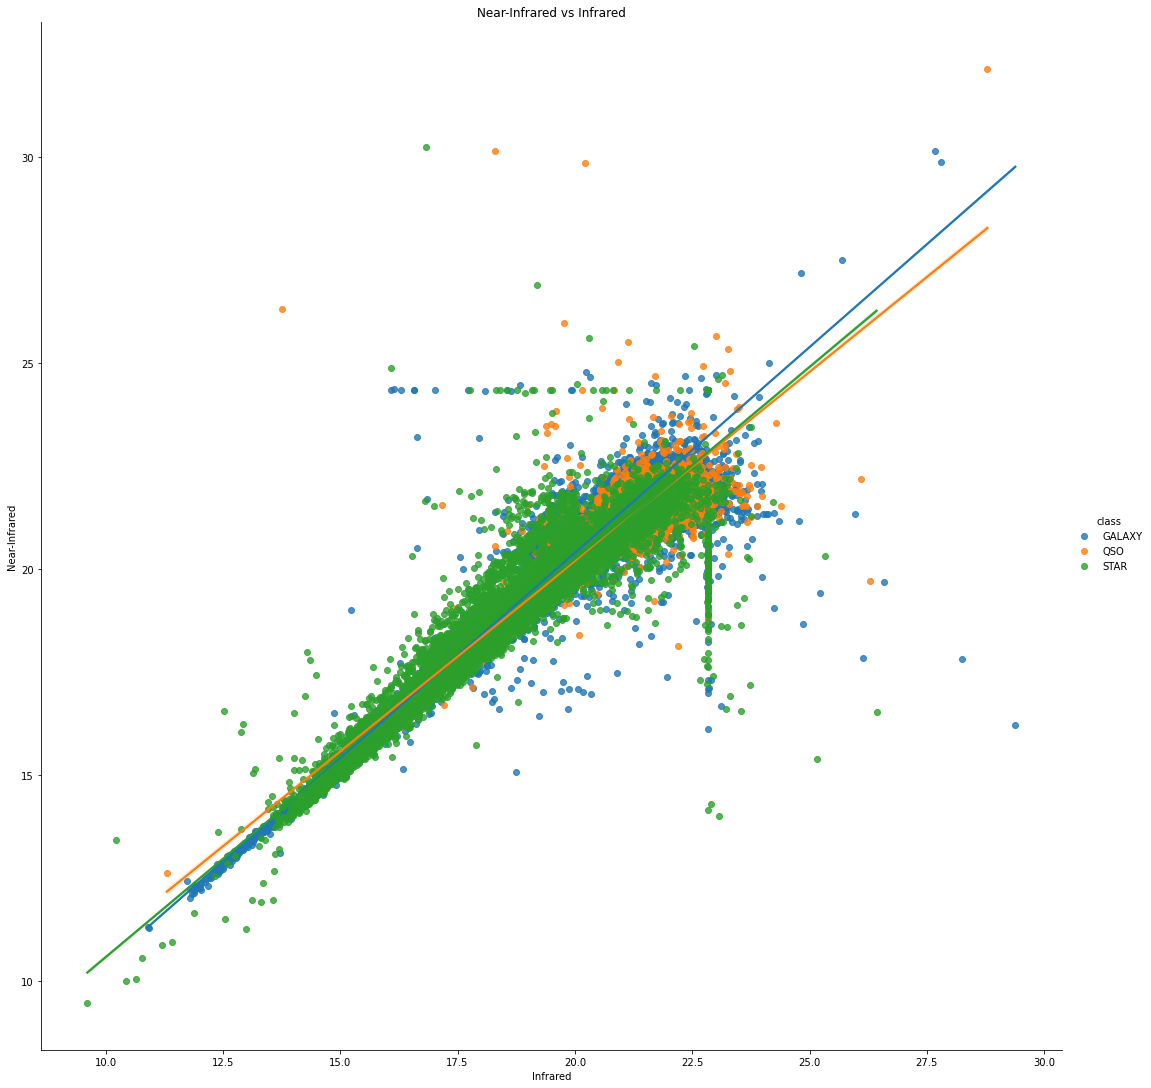

In [38]:
plt.figure(figsize = (15, 10))
sns.lmplot(data = df, x = 'z', y = 'i', hue = 'class', height = 15)
plt.title('Near-Infrared vs Infrared')
plt.xlabel('Infrared')
plt.ylabel('Near-Infrared');

Clear linear relationship between near-infrared and infrared emissions however, not a very useful visualiation because of how cluttered it is.

Plotting infrared vs ultraviolet (the emissions with the least correlation)

<Figure size 1080x720 with 0 Axes>

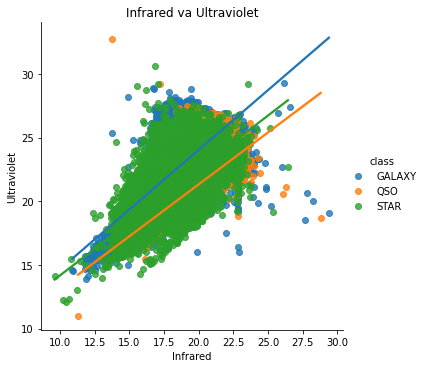

In [28]:
plt.figure(figsize = (15, 10))
sns.lmplot(data = df, x = 'z', y = 'u', hue = 'class')
plt.title('Infrared va Ultraviolet')
plt.xlabel('Infrared')
plt.ylabel('Ultraviolet');

Despite having the lowest correlation, the two still have a strong positive linear correlation. Again, this graphic is not useful for a presentaiton given that it is too cluttered.

Plotting Redshift vs Green light

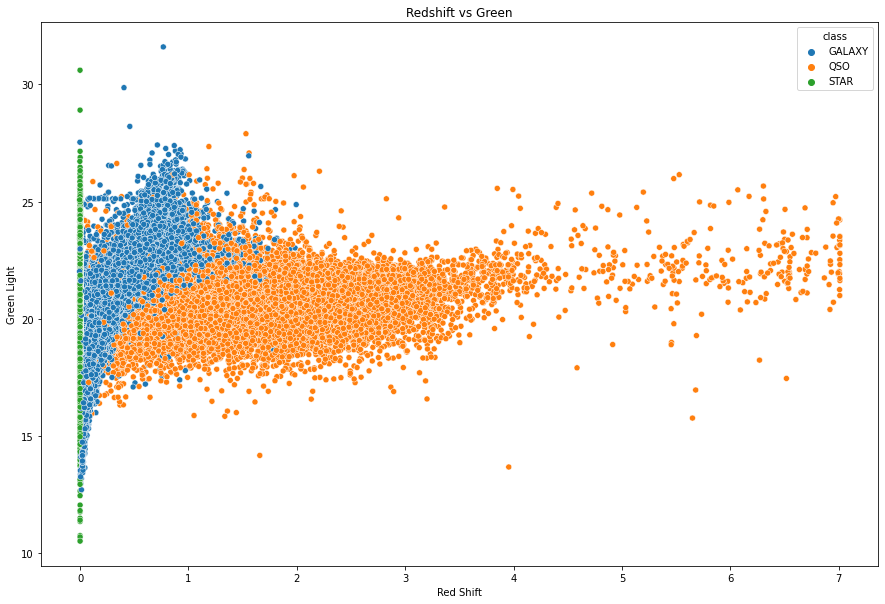

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = df['redshift'], y = df['g'], hue = df['class'])
plt.title('Redshift vs Green')
plt.xlabel('Red Shift')
plt.ylabel('Green Light');

Scatter plot shows general distinction between all three classes when comparing green light emitted and the redshift of each celestial object 

Plotting Red emission vs redshift

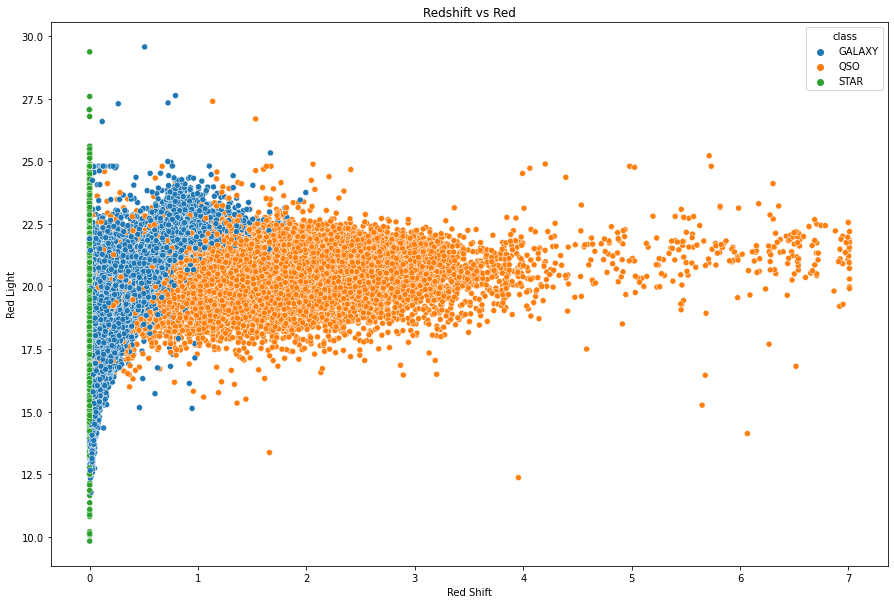

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = df['redshift'], y = df['r'], hue = df['class'])
plt.title('Redshift vs Red')
plt.xlabel('Red Shift')
plt.ylabel('Red Light');

Scatter plot shows general distinction between all three classes when comparing red light emitted and the redshift of each celestial object

Plotting Near-Infrared emission vs redshift

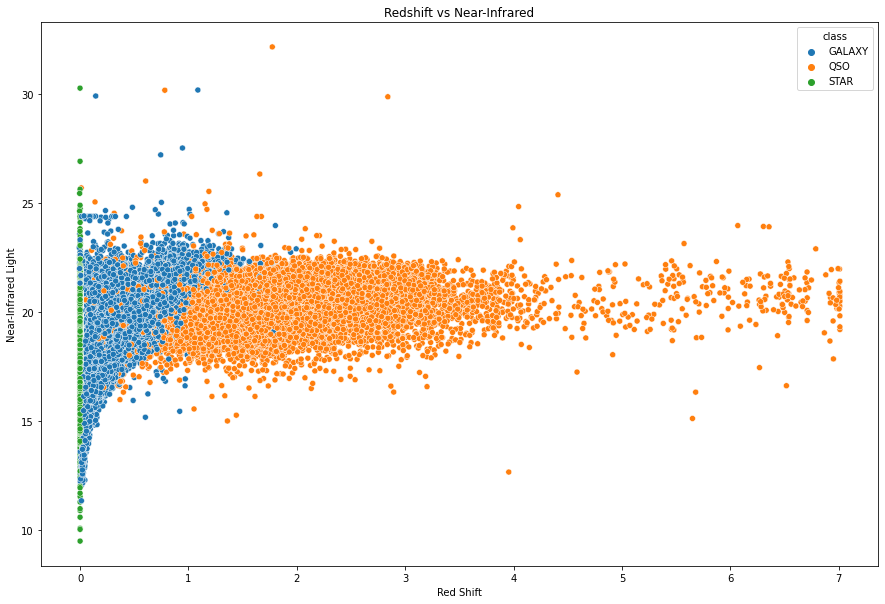

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = df['redshift'], y = df['i'], hue = df['class'])
plt.title('Redshift vs Near-Infrared')
plt.xlabel('Red Shift')
plt.ylabel('Near-Infrared Light');

Scatter plot shows general distinction between all three classes when comparing near-infrared light emitted and the redshift of each celestial object

Plotting infrared emission vs redshift

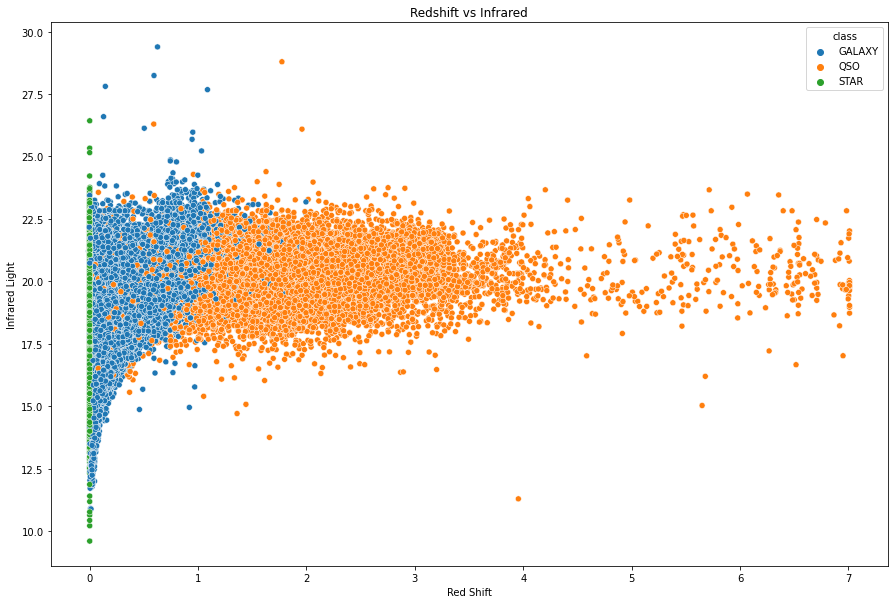

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = df['redshift'], y = df['z'], hue = df['class'])
plt.title('Redshift vs Infrared')
plt.xlabel('Red Shift')
plt.ylabel('Infrared Light');

Scatter plot shows general distinction between all three classes when comparing infrared light emitted and the redshift of each celestial object

Plotting Infrared va Near-Infrared (highest correlations according to HEATMAP)

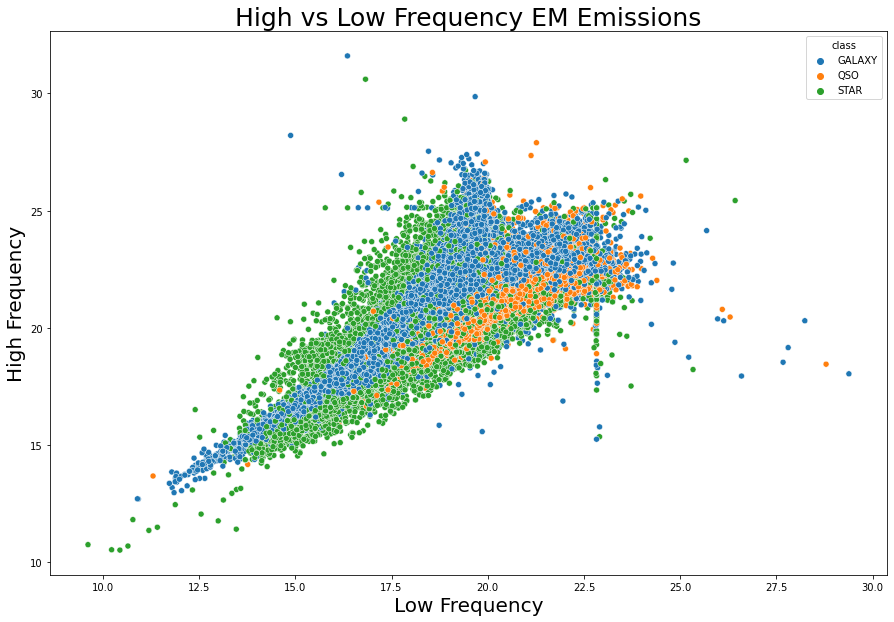

In [39]:
plt.figure(figsize = (15, 10))
sns.scatterplot(data = df, x = 'z', y = 'g', hue = 'class')
plt.title('High vs Low Frequency EM Emissions', fontsize = 25)
plt.xlabel('Low Frequency', fontsize = 20)
plt.ylabel('High Frequency', fontsize = 20)
plt.savefig('HIgh Low EM.png', dpi = 300, transparent = True, bbox_inches = 'tight');

The green light compared to infrared light best captures the overall relationship between the EM emissions and so I am using this demonstrate the general relationship

Plotting ultraviolet emission vs redshift

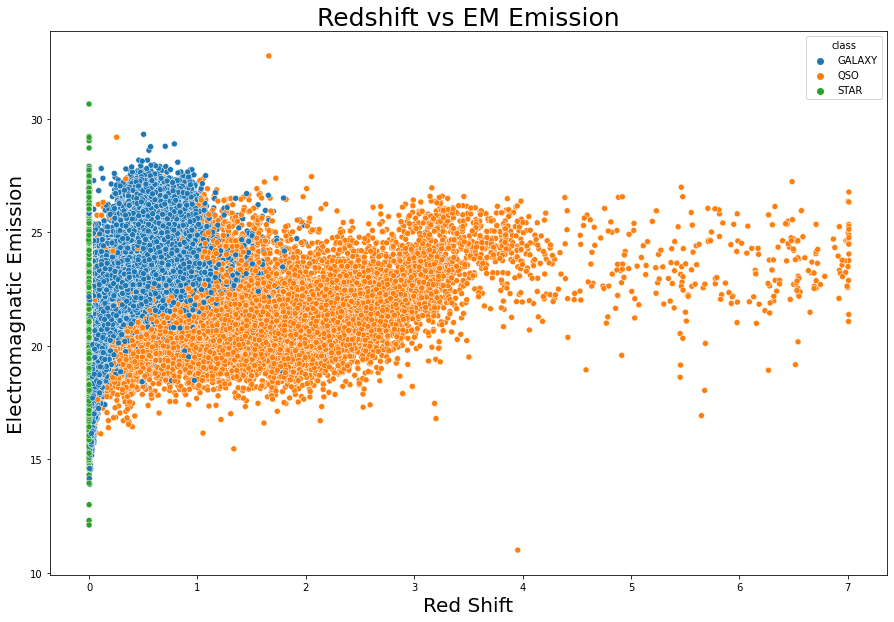

In [ ]:
plt.figure(figsize = (15, 10))
sns.scatterplot(x = df['redshift'], y = df['u'], hue = df['class'])
plt.title('Redshift vs EM Emission', fontsize = 25)
plt.xlabel('Red Shift', fontsize = 20)
plt.ylabel('Electromagnatic Emission', fontsize = 20);
plt.savefig('Redshift and Emissions.png', dpi = 300, transparent = True, bbox_inches = 'tight');

Scatter plot shows general distinction between all three classes when comparing ultraviolet light emitted and the redshift of each celestial object

---
Given the similarities between plots of each EM Emission and the redshift, I am using the ultraviolet emission as embliatic of all the EM emissions to demonstrat the relasionship between redshift, em emission and class. 

Plotting the relationship between class and redshift to portray similarities and differences.

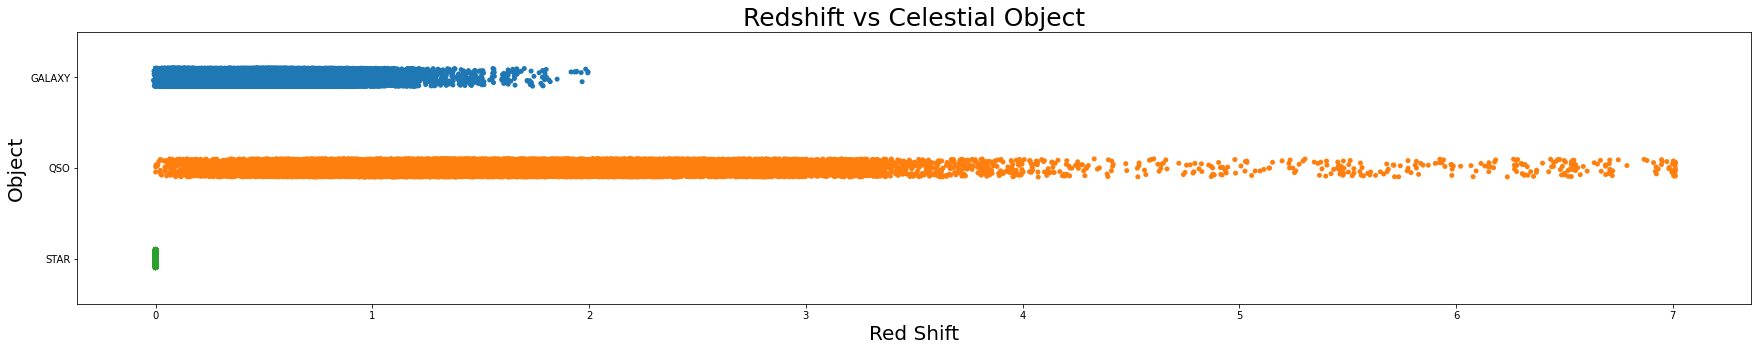

In [ ]:
plt.figure(figsize = (30, 5))
sns.stripplot(data = df, x = "redshift", y = "class")
plt.title('Redshift vs Celestial Object', fontsize = 25)
plt.xlabel('Red Shift', fontsize = 20)
plt.ylabel('Object', fontsize = 20);
plt.savefig('Redshift and Object.png', dpi = 300, transparent = True, bbox_inches = 'tight');

This plot shows the vast difference between class redshift but also the potential challenge of differentiating between classes based on redshift.